In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import random
import matplotlib.pylab as plt
from glob import glob
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

SETS_PATH = '../covid_dataset/'
LABELS = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

2021-10-12 10:36:52.677466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

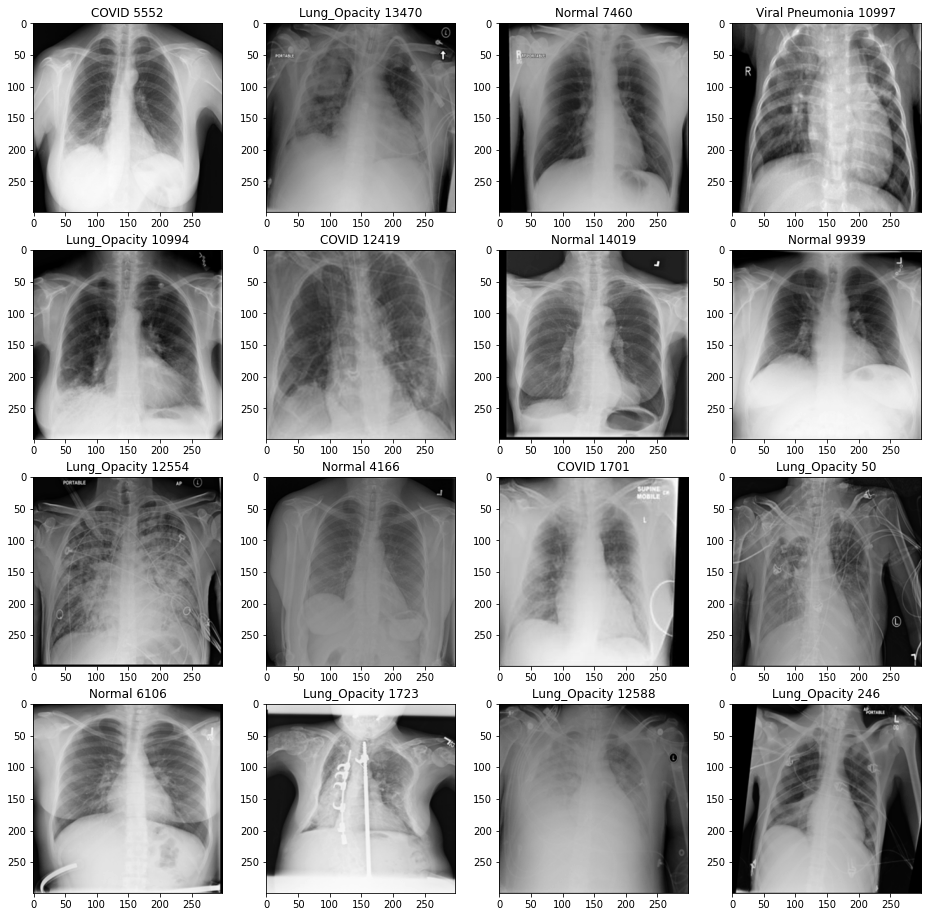

In [3]:
images_in_row = 4
random_indexes = random.choices(range(len(y_train)), k=images_in_row*images_in_row)
      
plt.figure(figsize=(16,16))
for j, index in enumerate(random_indexes):
    plt.subplot(images_in_row, images_in_row, j+1)
    plt.imshow(X_train[index], cmap='gray', vmax=1, vmin=0)
    plt.title(f'{LABELS[np.where(y_train[index]==1)[0][0]]} {index}')

In [3]:
my_model = Sequential()
my_model.add(Conv2D(64, kernel_size=(5,5), activation='relu', input_shape=[299,299, 1]))

my_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dropout(0.25))

my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))

my_model.add(Dense(128, activation='relu'))
my_model.add(Dropout(0.5))

my_model.add(Dense(4, activation='softmax'))

my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 295, 295, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 293, 293, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 146, 146, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 146, 146, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 72, 32)        0

2021-10-12 10:36:55.894617: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 10:36:55.895828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 10:36:55.911624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 10:36:55.911900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-10-12 10:36:55.911931: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-12 10:36:55.913527: I tensorflow/stream_executor/platform/def

In [4]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/5/epoch{epoch}.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
csv_logger = keras.callbacks.CSVLogger('history/history5.csv')

history = my_model.fit(X_train, y_train,
                     epochs=50, batch_size=16, callbacks=[callback,model_checkpoint_callback,csv_logger],
                     verbose=1, validation_data=(X_test, y_test))

2021-10-12 10:36:59.001516: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5297903260 exceeds 10% of free system memory.
2021-10-12 10:37:01.313764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-12 10:37:01.330930: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/50


2021-10-12 10:37:01.864359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-12 10:37:01.989933: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-12 10:37:02.627620: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-12 10:37:02.720431: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-12 10:37:04.325544: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-12 10:3

925/926 [============================>.] - ETA: 0s - loss: 1.1254 - accuracy: 0.5271

2021-10-12 10:42:12.762670: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-12 10:42:21.932236: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-12 10:42:22.603027: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


926/926 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.5272

2021-10-12 10:42:24.373233: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2270785400 exceeds 10% of free system memory.
2021-10-12 10:43:01.998575: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


926/926 [==============================] - 365s 380ms/step - loss: 1.1250 - accuracy: 0.5273 - val_loss: 0.7573 - val_accuracy: 0.7217
Epoch 2/50
926/926 [==============================] - 332s 359ms/step - loss: 0.7191 - accuracy: 0.7067 - val_loss: 0.6269 - val_accuracy: 0.7617
Epoch 3/50
926/926 [==============================] - 330s 357ms/step - loss: 0.5764 - accuracy: 0.7775 - val_loss: 0.5899 - val_accuracy: 0.7606
Epoch 4/50
926/926 [==============================] - 333s 360ms/step - loss: 0.5247 - accuracy: 0.8059 - val_loss: 0.5218 - val_accuracy: 0.7904
Epoch 5/50
926/926 [==============================] - 335s 362ms/step - loss: 0.4640 - accuracy: 0.8229 - val_loss: 0.4473 - val_accuracy: 0.8230
Epoch 6/50
926/926 [==============================] - 330s 356ms/step - loss: 0.4161 - accuracy: 0.8435 - val_loss: 0.4414 - val_accuracy: 0.8337
Epoch 7/50
926/926 [==============================] - 329s 355ms/step - loss: 0.3848 - accuracy: 0.8515 - val_loss: 0.4408 - val_accura

In [5]:
# my_model = keras.models.load_model('checkpoints/4/epoch8.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/5/epoch1_{epoch}.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
csv_logger = keras.callbacks.CSVLogger('history/history5_1.csv')

history = my_model.fit(X_train, y_train,
                     epochs=50, batch_size=16, callbacks=[callback,model_checkpoint_callback,csv_logger],
                     verbose=1, validation_data=(X_test, y_test))

2021-10-12 11:48:01.353579: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5297903260 exceeds 10% of free system memory.


Epoch 1/50
926/926 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9083

2021-10-12 11:52:56.249321: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2270785400 exceeds 10% of free system memory.


926/926 [==============================] - 328s 354ms/step - loss: 0.2547 - accuracy: 0.9083 - val_loss: 0.4653 - val_accuracy: 0.8472
Epoch 2/50
926/926 [==============================] - 328s 354ms/step - loss: 0.2387 - accuracy: 0.9140 - val_loss: 0.4826 - val_accuracy: 0.8343
Epoch 3/50
926/926 [==============================] - 328s 354ms/step - loss: 0.2295 - accuracy: 0.9174 - val_loss: 0.4094 - val_accuracy: 0.8655
Epoch 4/50
926/926 [==============================] - 328s 354ms/step - loss: 0.2163 - accuracy: 0.9197 - val_loss: 0.3759 - val_accuracy: 0.8680
Epoch 5/50
926/926 [==============================] - 328s 354ms/step - loss: 0.2091 - accuracy: 0.9255 - val_loss: 0.4584 - val_accuracy: 0.8523
Epoch 6/50
926/926 [==============================] - 329s 355ms/step - loss: 0.1978 - accuracy: 0.9291 - val_loss: 0.4110 - val_accuracy: 0.8635
Epoch 7/50
926/926 [==============================] - 328s 354ms/step - loss: 0.1924 - accuracy: 0.9329 - val_loss: 0.4060 - val_accura

In [6]:
my_model.save('checkpoints/5/epoch1_8.h5')